In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from ucsd_dataset import UCSDAnomalyDataset
from video_CAE import VideoAutoencoderLSTM
import torch.backends.cudnn as cudnn
import numpy as np
#matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
model = VideoAutoencoderLSTM()
criterion = nn.MSELoss()

use_cuda = torch.cuda.is_available()
if use_cuda:
    cudnn.benchmark = True
    model.set_cuda()
    criterion.cuda()
    
train_ds = UCSDAnomalyDataset('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train', time_stride=3)
train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-6, weight_decay=1e-5)

model.train()
for epoch in range(5):
    for batch_idx, x in enumerate(train_dl):
        optimizer.zero_grad()
        if use_cuda:
            x = x.cuda()
        y = model(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Epoch {}, iter {}: Loss = {}'.format(
            epoch, batch_idx, loss.item()))
    torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()},
        './snapshot/checkpoint.epoch{}.pth.tar'.format(epoch))

Epoch 0, iter 0: Loss = 3.20090651512146
Epoch 0, iter 10: Loss = 2.9104490280151367
Epoch 0, iter 20: Loss = 1.7151466608047485
Epoch 0, iter 30: Loss = 1.0485631227493286
Epoch 0, iter 40: Loss = 0.8794052600860596
Epoch 0, iter 50: Loss = 0.8220126032829285
Epoch 0, iter 60: Loss = 0.7974246144294739
Epoch 0, iter 70: Loss = 0.7844792604446411
Epoch 0, iter 80: Loss = 0.7760423421859741
Epoch 0, iter 90: Loss = 0.7704340219497681
Epoch 0, iter 100: Loss = 0.7659866213798523
Epoch 0, iter 110: Loss = 0.7625749111175537
Epoch 0, iter 120: Loss = 0.7596834301948547
Epoch 0, iter 130: Loss = 0.7571832537651062
Epoch 0, iter 140: Loss = 0.7550604343414307
Epoch 0, iter 150: Loss = 0.7532828450202942
Epoch 0, iter 160: Loss = 0.7515805959701538
Epoch 0, iter 170: Loss = 0.7501622438430786
Epoch 0, iter 180: Loss = 0.7488740086555481
Epoch 0, iter 190: Loss = 0.7478426694869995
Epoch 0, iter 200: Loss = 0.7467538118362427
Epoch 0, iter 210: Loss = 0.7458621859550476
Epoch 0, iter 220: Loss

In [ ]:
model = VideoAutoencoderLSTM()
model.load_state_dict(torch.load('./snapshot/checkpoint.epoch4.pth.tar')['state_dict'])

print(torch.__version__)
print(torch.version.cuda)
model.set_cuda()
model.eval()


2.4.1+cu118
11.8


C:\Users\jawhe\AppData\Local\Temp\ipykernel_16636\2432186105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./snapshot/checkpoint.epoc

VideoAutoencoderLSTM(
  (conv_encoder): Sequential(
    (conv1): Conv2d(1, 128, kernel_size=(11, 11), stride=(4, 4))
    (nonl1): Tanh()
    (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (nonl2): Tanh()
  )
  (rnn_enc_dec): ConvLSTM(
    (_all_layers): ModuleList(
      (0): ConvLSTMCell(
        (input_dropout): Dropout(p=0.5, inplace=False)
        (reccurent_drouput): Dropout(p=0.5, inplace=False)
        (Wxi): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whi): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxf): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whf): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxc): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Whc): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (Wxo): Conv2d(64, 64, kernel_size=(3, 3), stride

In [9]:
test_ds = UCSDAnomalyDataset('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test')

test_dl = data.DataLoader(test_ds, batch_size=32, shuffle=False)


In [24]:
frames = []
errors = []
for batch_idx, x in enumerate(test_dl):
    y = model(x.cuda())
    mse = torch.norm(x.cpu().data.view(x.size(0),-1) - y.cpu().data.view(y.size(0),-1), dim=1)
    errors.append(mse)
errors = torch.cat(errors).numpy()

In [25]:
errors.shape

(764,)

In [26]:
errors = errors.reshape(-1, 191)
s = np.zeros((4,191))
s[0,:] = 1 - (errors[0,:] - np.min(errors[0,:]))/(np.max(errors[0,:]) - np.min(errors[0,:]))
s[1,:] = 1 - (errors[1,:] - np.min(errors[1,:]))/(np.max(errors[1,:]) - np.min(errors[1,:]))
s[2,:] = 1 - (errors[2,:] - np.min(errors[2,:]))/(np.max(errors[2,:]) - np.min(errors[2,:]))
s[3,:] = 1 - (errors[3,:] - np.min(errors[3,:]))/(np.max(errors[3,:]) - np.min(errors[3,:]))

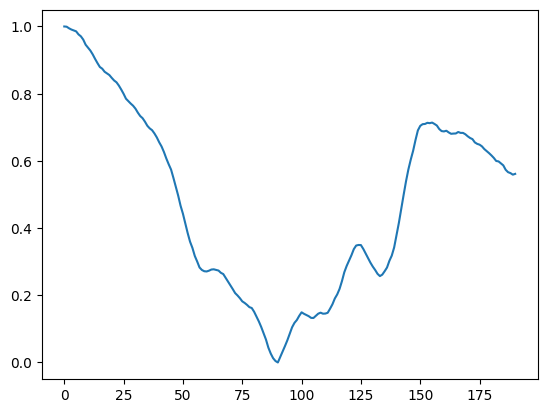

In [27]:
# Test001
plt.plot(s[0,:])
plt.show()

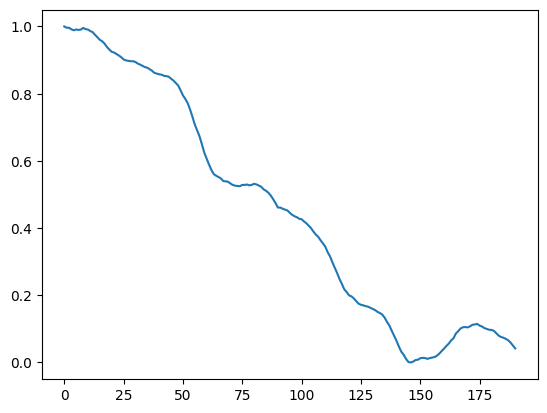

In [28]:
# Test02
plt.plot(s[1,:])
plt.show()

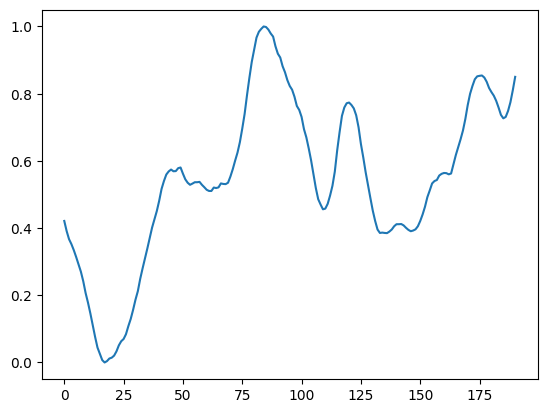

In [29]:
plt.plot(s[2,:])
plt.show()

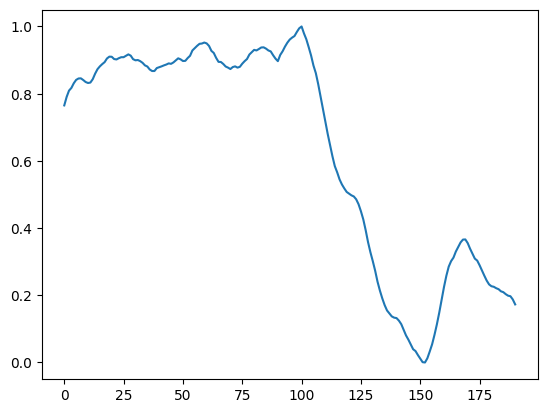

In [30]:
plt.plot(s[3,:])
plt.show()